## Spatial Data Assembling

This notebook recreates the "Spatial data assembling" tutorial in Python, covering how to assemble data from different spatial formats (raster and vector) and at different supports/scales, to build a table where each sampling location has soil depth plus covariate values.

### Goal
- In this tutorial we are going to cover one common topic in spatial data analaysis: how to assamble data from different formats (e.g. raster, vector) and supports/scales.

### Motivation
Suppose we want to map the soil depth at field scale. We went to the field and measured this attribute using a tedious and time consuming manual sampling. We could not sample every part of the field but we did our best effort and distributed our sampling points trying to cover it. By the order hand, we already have some soil and landscape covariates data collected using less expensive methods. Our idea is to develop some model based on this auxiliary data in order to map soil depth. To do that, each value of soil depth have to be matched with a value of the covariates.

### Available layers 
| Name                    | Type              | Description                          |
|-------------------------|-------------------|--------------------------------------|
| `F05_boundary.gpkg`     | vector (polygon)  | field boundary                        |
| `F05_EC_2008.gpkg`      | vector (points)   | soil EC survey from 2008              |
| `F05_EC_2009.gpkg`      | vector (points)   | soil EC survey from 2009              |
| `F05_hardpan.gpkg`      | vector (points)   | soil depth (cm)                       |
| `F05_DEM_RFsp_map.grd`  | raster (multi)    | DEM and derivatives                   |

Workflow:
- Data loading and CRS checks
- Raster to points extraction (nearest, bilinear, buffered median)
- Points to points joins (intersects, nearest, within-distance aggregation)
- Interpolation (IDW, k-NN, Ordinary Kriging)
- Optional saving of outputs


In [2]:
pip install rioxarray geopandas rasterio xarray shapely

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Imports and configuration
import sys
import warnings
warnings.filterwarnings("ignore")

# Core geospatial stack
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.vrt import WarpedVRT
from rasterio.enums import Resampling
import rioxarray as rxr
import xarray as xr

# Data manipulation and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Optional
# Nearest neighbor search
from scipy.spatial import cKDTree

# For spatial joins and buffers
from shapely.geometry import Point

# Optional kriging
try:
    from pykrige.ok import OrdinaryKriging
    _HAS_PYKRIGE = True
except Exception:
    _HAS_PYKRIGE = False

print("PyKrige available:", _HAS_PYKRIGE)


PyKrige available: True


### Data paths
Update the `data_dir` to the folder containing the provided layers. This notebook assumes it is run from the project directory shown in your workspace.


In [4]:
from pathlib import Path

# Use absolute path based on the workspace path
data_dir = Path("data")

# F05 dataset
path_boundary = data_dir / "F05_boundary.gpkg"
path_ec2008  = data_dir / "F05_EC_2008.gpkg"
path_ec2009  = data_dir / "F05_EC_2009.gpkg"
path_hpan    = data_dir / "F05_hardpan.gpkg"
path_dem_grd = data_dir / "F05_DEM_RFsp_map.grd"

for p in [path_boundary, path_ec2008, path_ec2009, path_hpan, path_dem_grd]:
    print(p, "exists:" , p.exists())


data/F05_boundary.gpkg exists: True
data/F05_EC_2008.gpkg exists: True
data/F05_EC_2009.gpkg exists: True
data/F05_hardpan.gpkg exists: True
data/F05_DEM_RFsp_map.grd exists: True


### Load data and inspect
We will load vector layers with GeoPandas and the raster with Rasterio. We'll also print CRS to ensure consistency.


CRS - hpan: EPSG:32721
CRS - ec2008: EPSG:32721
CRS - ec2009: EPSG:32721
CRS - boundary: EPSG:32721
CRS - dem_all: EPSG:32721


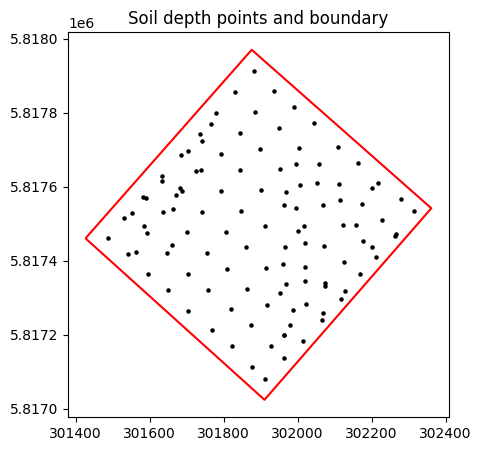

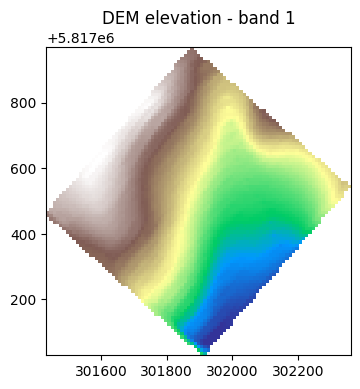

In [5]:
# Load vectors
hpan = gpd.read_file(path_hpan)
ec2008 = gpd.read_file(path_ec2008)
ec2009 = gpd.read_file(path_ec2009)
boundary = gpd.read_file(path_boundary)

# Load raster (all bands via rasterio)
with rasterio.open(path_dem_grd) as src:
    dem_all = src.read(masked=True)
    dem_elevation = dem_all[0]
    dem_transform = src.transform
    dem_crs = src.crs

print("CRS - hpan:", hpan.crs)
print("CRS - ec2008:", ec2008.crs)
print("CRS - ec2009:", ec2009.crs)
print("CRS - boundary:", boundary.crs)
print("CRS - dem_all:", dem_crs)

# Quick plots
ax = hpan.plot(figsize=(5,5), markersize=5, color='k')
boundary.boundary.plot(ax=ax, color='red')
plt.title('Soil depth points and boundary'); plt.show()

fig, ax = plt.subplots(figsize=(5,4))
show(dem_elevation, transform=dem_transform, ax=ax, cmap='terrain')
plt.title('DEM elevation - band 1'); plt.show()


In [6]:
ec2008.head()

,EC30,EC90,geometry
0,4.6,3.6,POINT (302308.387 5817537.340)
1,10.9,9.4,POINT (302306.563 5817532.522)
2,6.1,6.0,POINT (302302.807 5817527.435)
3,8.1,4.4,POINT (302297.023 5817526.075)
4,11.2,7.7,POINT (302286.192 5817514.601)


### CRS checks and harmonization
We need all layers to share a common CRS. We'll use the raster's CRS as the reference and reproject vectors as needed.


In [9]:
target_crs = dem_crs

if hpan.crs != target_crs:
    hpan = hpan.to_crs(target_crs)
if ec2008.crs != target_crs:
    ec2008 = ec2008.to_crs(target_crs)
if ec2009.crs != target_crs:
    ec2009 = ec2009.to_crs(target_crs)
if boundary.crs != target_crs:
    boundary = boundary.to_crs(target_crs)

print("All vectors reprojected to:", target_crs)


All vectors reprojected to: EPSG:32721


### Raster to points: sample values at point locations
- Nearest cell center (simple)
- Bilinear interpolation
- Buffered extraction with summary function (e.g., median)


In [17]:
# 1) Simple nearest sampling from all bands (similar to R's extract(DEM_all, hpan))
coords = [(geom.x, geom.y) for geom in hpan.geometry]
with rasterio.open(path_dem_grd) as src:
    # Extract all bands at point locations (like R's extract(DEM_all, hpan))
    # src.sample returns arrays with one value per band per coordinate
    all_band_vals = list(src.sample(coords))
    # Convert to numpy array: shape will be (n_points, n_bands)
    ext_smpl = np.array(all_band_vals)
    
    # Create column names for each band (band_1, band_2, etc.)
    n_bands = src.count
    band_cols = [f"band_{i+1}" for i in range(n_bands)]
    
    # Add all bands to hpan dataframe
    for i, col_name in enumerate(band_cols):
        hpan[col_name] = ext_smpl[:, i]

# For backward compatibility, also create elevation_nearest (same as band_1)
hpan = hpan.copy()
hpan["elevation_nearest"] = hpan["band_1"]

# 2) Bilinear sampling using WarpedVRT with bilinear resampling
with rasterio.open(path_dem_grd) as src:
    with WarpedVRT(src, resampling=Resampling.bilinear) as vrt:
        bil_vals = [vals[0] for vals in vrt.sample(coords, indexes=1)]

hpan["elevation_bilinear"] = np.array(bil_vals).reshape(-1)

# 3) Buffered extraction (median) over all bands (like R's extract(DEM_all, hpan, buffer = 20, fun = median))
# We'll compute median within a radius (meters) around each point by windowing pixels
buffer_radius = 20.0  # meters

with rasterio.open(path_dem_grd) as src:
    transform = src.transform
    res_x = transform.a
    res_y = -transform.e
    px_radius_x = max(1, int(np.ceil(buffer_radius / abs(res_x))))
    px_radius_y = max(1, int(np.ceil(buffer_radius / abs(res_y))))
    n_bands = src.count

    # For each band, compute median values within buffer
    for band_idx in range(1, n_bands + 1):
        medians = []
        for x, y in coords:
            row, col = src.index(x, y)
            window = rasterio.windows.Window(col - px_radius_x, row - px_radius_y,
                                             2 * px_radius_x + 1, 2 * px_radius_y + 1)
            data = src.read(band_idx, window=window, masked=True)
            med = np.nanmedian(data) if data.size > 0 else np.nan
            medians.append(med)
        
        hpan[f"band_{band_idx}_buffer20_median"] = medians

# For backward compatibility, keep elevation_buffer20_median as band_1
hpan["elevation_buffer20_median"] = hpan["band_1_buffer20_median"]

hpan.head()


,hpdepth,geometry,elevation_nearest,elevation_bilinear,elevation_buffer20_median,EC30_idw,EC90_idw,EC30_knn10,EC90_knn10
0,101.0,POINT (302315.586 5817535.628),216.460007,216.460007,216.454788,12.290625,7.499699,20.99,10.33
1,101.0,POINT (302279.551 5817568.072),215.566833,215.566833,215.583160,16.428330,13.209759,19.52,13.26
2,101.0,POINT (302216.822 5817610.980),215.315872,215.315872,215.322845,10.015607,5.863051,13.03,8.56
3,101.0,POINT (302162.635 5817665.195),216.625641,216.625641,216.601181,11.222544,6.887034,10.10,6.18
4,101.0,POINT (302108.713 5817708.313),218.483871,218.483871,218.476822,6.107717,3.627179,7.33,4.74


### Plot raster and points together
Similar to the R code: plot(DEM_elevation) followed by plot(hpan, add = T, pch = "+", col = "black")


In [ ]:
# Plot DEM elevation raster
with rasterio.open(path_dem_grd) as src:
    fig, ax = plt.subplots(figsize=(8, 6))
    show(src, ax=ax, cmap='terrain')
    # Overlay hardpan points
    hpan.plot(ax=ax, color='black', markersize=30, marker='+')
    plt.title('DEM Elevation with Hardpan Points')
    plt.show()


### Points to points joins
Options shown:
- Spatial join with intersects (may miss non-coincident points)
- Nearest feature join
- Within-distance join and aggregation (e.g., mean EC30/EC90 within 5–10 m)


In [18]:
# 1) Intersects (exactly coincident)
try:
    joined_intersects = gpd.sjoin(hpan, ec2009, predicate="intersects", how="left")
except TypeError:
    # For older geopandas versions
    joined_intersects = gpd.sjoin(hpan, ec2009, op="intersects", how="left")

joined_intersects.head()

# 2) Nearest feature join (1:1)
def nearest_join(left: gpd.GeoDataFrame, right: gpd.GeoDataFrame, right_on_cols):
    left_centroids = np.vstack([left.geometry.x.values, left.geometry.y.values]).T
    right_centroids = np.vstack([right.geometry.x.values, right.geometry.y.values]).T
    tree = cKDTree(right_centroids)
    dist, idx = tree.query(left_centroids, k=1)
    right_sel = right.reset_index(drop=True).iloc[idx][right_on_cols].reset_index(drop=True)
    out = left.reset_index(drop=True).join(right_sel)
    out["nearest_dist_m"] = dist
    return out

# Select EC columns to bring over (if present)
ec_cols = [c for c in ec2009.columns if c.lower() in ("ec30", "ec90")]
if not ec_cols:
    # fallback: try common names
    ec_cols = [c for c in ec2009.columns if "EC" in c.upper()]

hpan_nearest = nearest_join(hpan, ec2009, right_on_cols=ec_cols)

# 3) Within-distance join and aggregation
search_radius = 10.0  # meters

# Build buffers
hpan_buf = hpan.copy()
hpan_buf["buffer_geom"] = hpan_buf.geometry.buffer(search_radius)

# Spatial index for ec2009
ec_sindex = ec2009.sindex

agg_results = []
for i, buf in enumerate(hpan_buf["buffer_geom"]):
    # candidate indices
    candidate_idx = list(ec_sindex.intersection(buf.bounds))
    candidates = ec2009.iloc[candidate_idx]
    inside = candidates[candidates.intersects(buf)]
    if inside.empty:
        agg_results.append({"EC30_mean": np.nan, "EC90_mean": np.nan, "n_pts": 0})
    else:
        vals = {}
        if "EC30" in inside.columns:
            vals["EC30_mean"] = inside["EC30"].astype(float).mean()
        else:
            vals["EC30_mean"] = np.nan
        if "EC90" in inside.columns:
            vals["EC90_mean"] = inside["EC90"].astype(float).mean()
        else:
            vals["EC90_mean"] = np.nan
        vals["n_pts"] = len(inside)
        agg_results.append(vals)

agg_df = pd.DataFrame(agg_results)
hpan_within_agg = hpan.reset_index(drop=True).join(agg_df)

hpan_nearest.head(), hpan_within_agg.head()


(   hpdepth                        geometry  elevation_nearest  \
 0    101.0  POINT (302315.586 5817535.628)         216.460007   
 1    101.0  POINT (302279.551 5817568.072)         215.566833   
 2    101.0  POINT (302216.822 5817610.980)         215.315872   
 3    101.0  POINT (302162.635 5817665.195)         216.625641   
 4    101.0  POINT (302108.713 5817708.313)         218.483871   
 
    elevation_bilinear  elevation_buffer20_median   EC30_idw   EC90_idw  \
 0          216.460007                 216.454788  12.290625   7.499699   
 1          215.566833                 215.583160  16.428330  13.209759   
 2          215.315872                 215.322845  10.015607   5.863051   
 3          216.625641                 216.601181  11.222544   6.887034   
 4          218.483871                 218.476822   6.107717   3.627179   
 
    EC30_knn10  EC90_knn10  EC30  EC90  nearest_dist_m  
 0       20.99       10.33  17.0  19.0       14.341959  
 1       19.52       13.26  15.3  15

### Interpolation methods
We'll demonstrate:
- IDW (Inverse Distance Weighting)
- k-NN (nearest-neighbor equivalence with idp=0 concept)
- Ordinary Kriging (if PyKrige is installed)


In [14]:
from typing import Optional

def idw_predict(train_xy: np.ndarray, train_vals: np.ndarray, query_xy: np.ndarray, power: float = 2.0, nmax: Optional[int] = None):
    # Efficient IDW with optional nmax nearest neighbors
    tree = cKDTree(train_xy)
    if nmax is None:
        # query all points (may be slow); use a reasonable default nmax
        nmax = 16
    dists, idxs = tree.query(query_xy, k=nmax)
    # Ensure 2D arrays
    dists = np.atleast_2d(dists)
    idxs = np.atleast_2d(idxs)
    # Avoid div-by-zero: if any distance is 0, copy that value directly
    preds = np.empty(query_xy.shape[0], dtype=float)
    for i in range(query_xy.shape[0]):
        di = dists[i]
        ii = idxs[i]
        if np.any(di == 0):
            preds[i] = train_vals[ii[di == 0][0]]
        else:
            wi = 1.0 / (di ** power)
            preds[i] = np.sum(wi * train_vals[ii]) / np.sum(wi)
    return preds

# Prepare training from EC2008 (as in the R example)
# Use EC30 and EC90 if present
if "EC30" in ec2008.columns and "EC90" in ec2008.columns:
    train_xy = np.column_stack([ec2008.geometry.x.values, ec2008.geometry.y.values])
    train_ec30 = ec2008["EC30"].astype(float).values
    train_ec90 = ec2008["EC90"].astype(float).values
else:
    # If different column names, try to detect numeric columns as proxy
    num_cols = ec2008.select_dtypes(include=[np.number]).columns
    if len(num_cols) >= 2:
        train_xy = np.column_stack([ec2008.geometry.x.values, ec2008.geometry.y.values])
        train_ec30 = ec2008[num_cols[0]].astype(float).values
        train_ec90 = ec2008[num_cols[1]].astype(float).values
    else:
        raise ValueError("EC columns not found in ec2008; please adjust column names.")

query_xy = np.column_stack([hpan.geometry.x.values, hpan.geometry.y.values])

# IDW predictions
hpan["EC30_idw"] = idw_predict(train_xy, train_ec30, query_xy, power=2.0, nmax=16)
hpan["EC90_idw"] = idw_predict(train_xy, train_ec90, query_xy, power=2.0, nmax=16)

# k-NN (idp=0 equivalent): majority vote not applicable for numeric; we can use mean of k nearest
# With idp=0, prediction becomes mean of k nearest neighbors
def knn_mean_predict(train_xy: np.ndarray, train_vals: np.ndarray, query_xy: np.ndarray, k: int = 10):
    tree = cKDTree(train_xy)
    dists, idxs = tree.query(query_xy, k=k)
    idxs = np.atleast_2d(idxs)
    return np.mean(train_vals[idxs], axis=1)

hpan["EC30_knn10"] = knn_mean_predict(train_xy, train_ec30, query_xy, k=10)
hpan["EC90_knn10"] = knn_mean_predict(train_xy, train_ec90, query_xy, k=10)

# Ordinary Kriging (if available)
if _HAS_PYKRIGE:
    # PyKrige expects 1D arrays; fit per variable
    OK30 = OrdinaryKriging(
        train_xy[:,0], train_xy[:,1], train_ec30,
        variogram_model='exponential',
        verbose=False,
        enable_plotting=False
    )
    z30, ss30 = OK30.execute('points', query_xy[:,0], query_xy[:,1])
    hpan["EC30_ok"] = np.asarray(z30)

    OK90 = OrdinaryKriging(
        train_xy[:,0], train_xy[:,1], train_ec90,
        variogram_model='exponential',
        verbose=False,
        enable_plotting=False
    )
    z90, ss90 = OK90.execute('points', query_xy[:,0], query_xy[:,1])
    hpan["EC90_ok"] = np.asarray(z90)
else:
    print("PyKrige not installed; skipping kriging.")

hpan.head()


PyKrige not installed; skipping kriging.


,hpdepth,geometry,elevation_nearest,elevation_bilinear,elevation_buffer20_median,EC30_idw,EC90_idw,EC30_knn10,EC90_knn10
0,101.0,POINT (302315.586 5817535.628),216.460007,216.460007,216.454788,12.290625,7.499699,20.99,10.33
1,101.0,POINT (302279.551 5817568.072),215.566833,215.566833,215.583160,16.428330,13.209759,19.52,13.26
2,101.0,POINT (302216.822 5817610.980),215.315872,215.315872,215.322845,10.015607,5.863051,13.03,8.56
3,101.0,POINT (302162.635 5817665.195),216.625641,216.625641,216.601181,11.222544,6.887034,10.10,6.18
4,101.0,POINT (302108.713 5817708.313),218.483871,218.483871,218.476822,6.107717,3.627179,7.33,4.74


### Save outputs and quick plots
Optionally, save enriched `hpan` with extracted/joined/interpolated attributes, and produce a couple of quick plots for sanity checks.


Saved: /Users/emine2/Documents/CLASSES/01_2024-FALL/CPSC-444_SpatialAnalysis/Module_4/Module 4/Soil Detph Case Study/F05_hpan_enriched_python.gpkg


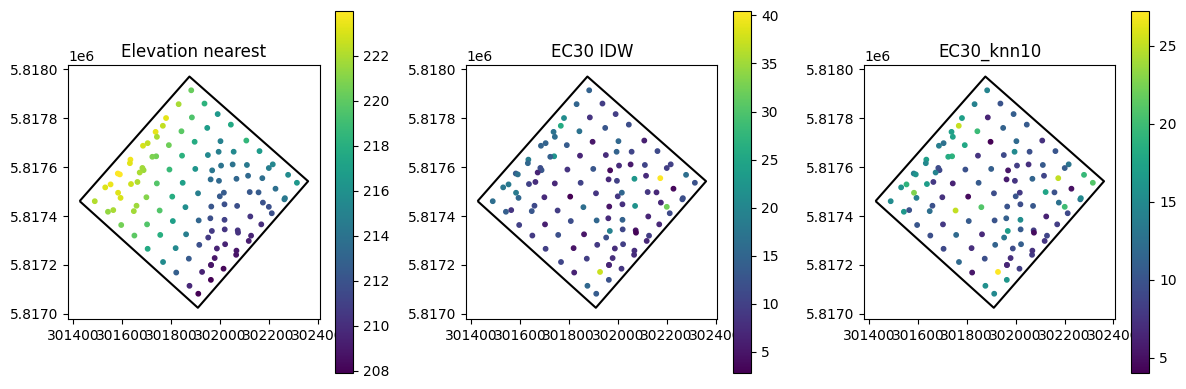

In [15]:
# Save enriched points
out_gpkg = data_dir / "F05_hpan_enriched_python.gpkg"
try:
    hpan.to_file(out_gpkg, driver="GPKG")
    print("Saved:", out_gpkg)
except Exception as e:
    print("Could not save GPKG:", e)

# Quick plots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
hpan.plot(column="elevation_nearest", ax=axes[0], legend=True, markersize=10)
axes[0].set_title("Elevation nearest")

hpan.plot(column="EC30_idw", ax=axes[1], legend=True, markersize=10)
axes[1].set_title("EC30 IDW")

col_ok = "EC30_ok" if "EC30_ok" in hpan.columns else "EC30_knn10"
hpan.plot(column=col_ok, ax=axes[2], legend=True, markersize=10)
axes[2].set_title(col_ok)

for ax in axes:
    boundary.boundary.plot(ax=ax, color='k')
plt.tight_layout(); plt.show()
